In [1]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
############### upload data
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import pandas as pd

import torch
import torch.optim as optim

import torchtext
from torchtext import data
import spacy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import argparse
import os


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Baseline(nn.Module):

    def __init__(self, embedding_dim, vocab):
        super(Baseline, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.fc = nn.Linear(embedding_dim, 6)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)

        average = embedded.mean(0)
        output = self.fc(average)
        output = nn.functional.relu(output)
        return output

In [13]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim=100):
        super(CNN_LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.hidden_dim = hidden_dim

        self.conv1 = nn.Conv2d(1, 100,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        
        
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        target_size = 6
        self.fc1 = nn.Linear(hidden_dim, target_size)

    def forward(self, x, lengths):
    #   embeds = self.word_embeddings(sentence)
    #     lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    #     tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    #     tag_scores = F.log_softmax(tag_space, dim=1)
    #     return tag_scores
        
        x = self.embedding(x)
        # print('x.shape',x.shape)

        x = x.unsqueeze(0)
        # print('x = x.unsqueeze(0)',x.shape)
        x = x.transpose(1,2) # swaps 2nd and 3rd dimension
        # print('x = x.transpose(1,2)',x.shape)
        x = x.transpose(0,1) # swaps 1st and 2nd dimension, now it has the correct input (n_samples,channels, height, width)
        # print('x = x.transpose(0,1)',x.shape)
        x1 = F.relu(self.conv1(x)) 
        # print('x1 = F.relu(self.conv1(x))',x1.shape)
        
        x1 = x1.squeeze(3)
        # print('x1 = x1.squeeze(3)',x1.shape)
        pool1 = nn.MaxPool1d(x1.size(2), 1) #maxpool
        
        x = pool1(x1)
        # print('pool1 = nn.MaxPool1d(x1.size(2), 1)',x.shape)
        x = x.squeeze(2)
        x = x.unsqueeze(0)
        # print('x = x.squeeze(2)',x.shape)


        #  pack the word embeddings in the batch together and 
        # run the RNN on this object
        # x = pack_padded_sequence(x,lengths) 
        # print('x.shape',x.shape)
        x,(h,c) = self.lstm1(x)
        # print('x.shape',x.shape)
        # print('h.shape',h.shape)
        # print('len(h)',len(h))
        # print('(x.view(len(lengths),-1)).shape',(x.view(len(lengths),-1)).shape)
        # h_result = self.fc1(h.squeeze(0))
        # h_result = F.log_softmax(target_size, dim=1) --> change to this with multiple cat
        h_result = torch.sigmoid(h_result)
        

        return h_result.squeeze(1)

In [8]:
def evaluate(model, data_iter, loss_fnc):
    sumloss = 0
    sumcorrect = 0
    for i, texts in enumerate(data_iter):
        words, length = texts.comment_text
        labels = []
        for i in range(len(texts.toxic)):
            labels += [[int(texts.toxic[i]), int(texts.severe_toxic[i]), int(texts.obscene[i]), int(texts.threat[i]), int(texts.insult[i]), int(texts.identity_hate[i])]]
        out = model(words, length)
        temploss = loss_fnc(input=out.squeeze(), target=torch.FloatTensor(labels))
        sumloss += temploss
        temp = ((out > 0.5).squeeze().long() == torch.FloatTensor(labels))
        correct = 0
        for i in temp:
          if torch.equal(i, torch.BoolTensor([True, True, True, True, True, True])):
            correct += 1
    loss = torch.mean(float(sumloss) / (i + 1))
    return float(correct)/len(data_iter.dataset), loss

In [9]:
def plot_data(train_acc, valid_acc, test_acc, train_loss, valid_loss, test_loss):

    plt.figure()
    plt.title("Accuracy")
    plt.plot(train_acc, label="Training")
    plt.plot(valid_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.figtext(0.5, -0.05, "Training Final Accuracy: " + str(train_acc[-1]), wrap=True, horizontalalignment='center', fontsize=12)
    plt.figtext(0.5, -0.1, "Validation Final Accuracy: " + str(valid_acc[-1]), wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, label="Training")
    plt.plot(valid_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [21]:
def baselinetrain(batch_size, lr, epochs, emb_dim):
    ######
    # 3.2 Processing of the data
    # the code below assumes you have processed and split the data into
    # the three files, train.tsv, validation.tsv and test.tsv
    # and those files reside in the folder named "data".
    ######

    COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
    TOXIC           = data.Field(sequential=False, use_vocab=False)
    SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
    OBSCENE         = data.Field(sequential=False, use_vocab=False)
    THREAT          = data.Field(sequential=False, use_vocab=False)
    INSULT          = data.Field(sequential=False, use_vocab=False)
    IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)

    train_data, val_data, test_data = data.TabularDataset.splits(
            path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/processed_data/', train='train.csv',
            validation='valid.csv', test='test.csv', format='csv',
            skip_header=True, fields=[('id', None), ('comment_text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])

    train_iter, val_iter, test_iter = data.BucketIterator.splits(
          (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),
	sort_key=lambda x: len(x.comment_text), device=None, sort_within_batch=True, repeat=False)

    COMMENT_TEXT.build_vocab(train_data, val_data, test_data)

    COMMENT_TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
    vocab = COMMENT_TEXT.vocab

    # print("Shape of Vocab:",COMMENT_TEXT.vocab.vectors.shape)

    filters = (2, 4)
    loss_fnc = torch.nn.MSELoss()
    model = CNN_LSTM(emb_dim, COMMENT_TEXT.vocab)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_acc = []
    train_loss = []
    valid_acc = []
    valid_loss = []
    test_acc = []
    test_loss = []
    for epoch in range(epochs):
        for i, texts in enumerate(train_iter):
            words, length = texts.comment_text
            labels = []
            for i in range(len(texts.toxic)):
              labels += [[int(texts.toxic[i]), int(texts.severe_toxic[i]), int(texts.obscene[i]), int(texts.threat[i]), int(texts.insult[i]), int(texts.identity_hate[i])]]
            optimizer.zero_grad()
            out = model(words, length)
            # print(out.size())
            # print(torch.FloatTensor(labels).size())
            temploss = loss_fnc(input=out.squeeze(), target=torch.FloatTensor(labels))
            temploss.backward()
            optimizer.step()

        train = evaluate(model, train_iter, loss_fnc)
        train_acc.append(train[0])
        train_loss.append(train[1].numpy())
        val = evaluate(model, val_iter, loss_fnc)
        valid_acc.append(val[0])
        valid_loss.append(val[1].numpy())
        test = evaluate(model, test_iter, loss_fnc)
        test_acc.append(test[0])
        test_loss.append(test[1].numpy())
        print("Epoch: {}| Train acc: {} | Train loss: {} |  Valid acc: {} |  Valid loss: {}".format(epoch + 1, train_acc[epoch], train_loss[epoch],valid_acc[epoch], valid_loss[epoch]))

    plot_data(train_acc, valid_acc, test_acc, train_loss, valid_loss, test_loss)


Epoch: 1| Train acc: 0.001810477657935285 | Train loss: 36.48095703125 |  Valid acc: 0.007090012330456227 |  Valid loss: 4.561610698699951
Epoch: 2| Train acc: 0.001386748844375963 | Train loss: 36.592777252197266 |  Valid acc: 0.007090012330456227 |  Valid loss: 4.576289653778076
Epoch: 3| Train acc: 0.0013482280431432975 | Train loss: 54.90350341796875 |  Valid acc: 0.007090012330456227 |  Valid loss: 4.576704025268555
Epoch: 4| Train acc: 0.0010785824345146378 | Train loss: 48.792720794677734 |  Valid acc: 0.007090012330456227 |  Valid loss: 4.576704025268555
Epoch: 5| Train acc: 0.0009244992295839754 | Train loss: 48.80729293823242 |  Valid acc: 0.007090012330456227 |  Valid loss: 4.576704025268555
Epoch: 6| Train acc: 0.0010400616332819723 | Train loss: 54.89178466796875 |  Valid acc: 0.007090012330456227 |  Valid loss: 4.576704025268555
Epoch: 7| Train acc: 0.0008089368258859784 | Train loss: 36.6093864440918 |  Valid acc: 0.007090012330456227 |  Valid loss: 4.576704025268555
Epo

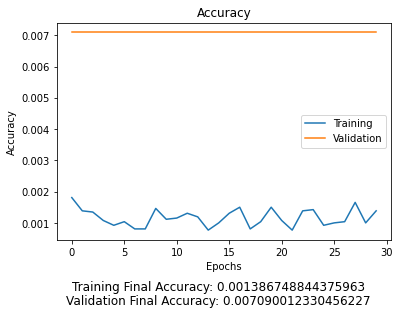

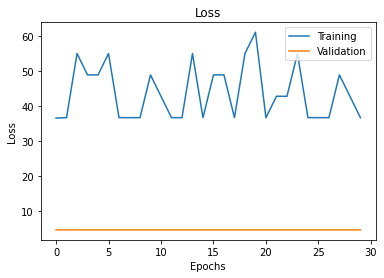

In [22]:
baselinetrain(64, 0.1, 30, 100)